# IBM: Supervised Machine Learning Project

In this project the main goal is to predict heart failure based on multiple features as shown in the later sections.
The dataset which is used for this project is pulled from kaggle:
https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

## Packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Description

In [3]:
dataPath = "data\heart.csv"

In [4]:
heart_df = pd.read_csv(dataPath)
heart_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [5]:
heart_df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [6]:
heart_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
cols = heart_df.columns.to_list()

The dataset consists out of the following columns: 'Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease' with 918 samples.

## Data Preprocessing

In [8]:
#check for duplicates & missing values
heart_df = heart_df.drop_duplicates()
heart_df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

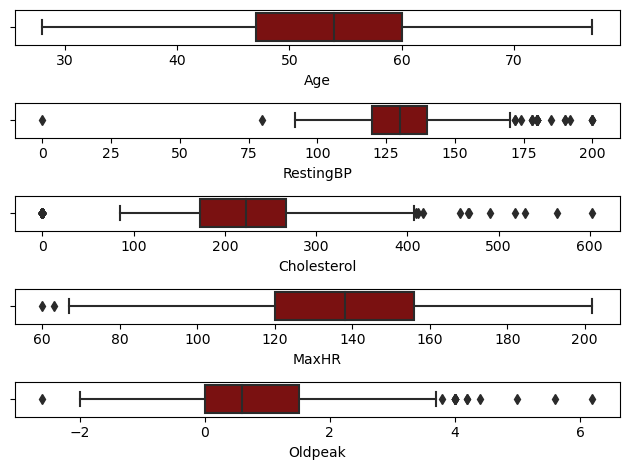

In [9]:
#checking for outliers
#Makes only sense for continous variables: Age, RestingBP, Cholesterol, MaxHR, Oldpeak
out_checkvars = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
fig, axes = plt.subplots(5,1)
for index, column in enumerate(heart_df[out_checkvars].columns):
    sns.boxplot(x=column, ax=axes[index], data=heart_df[out_checkvars], color="darkred")
plt.tight_layout()

##### These boxplots show that especially RestingBP, Cholesterol and Oldpeak have a number of outliers, which need to be taken into acount. We gonna remove these by calculating the Whiskers Boundaries and filtering the data based on these boundaries.

In [10]:
cleaned_heart_df = heart_df.copy()
for column in out_checkvars:
    Q1 = heart_df[column].quantile(0.25)
    Q3 = heart_df[column].quantile(0.75)
    IQR = Q3-Q1
    lower_whiskers_bound = Q1 - 1.5 * IQR
    upper_whiskers_bound = Q3 + 1.5 * IQR
    cleaned_heart_df = cleaned_heart_df[(cleaned_heart_df[column] >= lower_whiskers_bound) & (cleaned_heart_df[column] <= upper_whiskers_bound)]

In [11]:
cleaned_heart_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


##### We now cleaned the dataset from all outliers. But we also need to transform the binary and ordinal variables to numbers in order to use them for our machine learning model approaches.

In [12]:
NonContinousVars = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

In [13]:
LE = preprocessing.LabelEncoder()

In [14]:
for column in NonContinousVars:
    if column in cleaned_heart_df.columns:
        cleaned_heart_df[column] = LE.fit_transform(cleaned_heart_df[column])

In [15]:
cleaned_heart_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


In [16]:
cleaned_heart_df.dtypes

Age                 int64
Sex                 int32
ChestPainType       int32
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG          int32
MaxHR               int64
ExerciseAngina      int32
Oldpeak           float64
ST_Slope            int32
HeartDisease        int64
dtype: object

#### We now accomplished our data exploration and data cleaning. Our data is ready to be used for splitting and modeling.

In [17]:
features = cleaned_heart_df.drop("HeartDisease", axis=1)
labels = cleaned_heart_df["HeartDisease"]
rs = 178

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=rs)

In [19]:
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

X_train shape: (470, 11)
X_test shape: (232, 11)
y_train shape: (470,)
y_test shape: (232,)


## Modeling

### Logistic Regression

In [20]:
LR = LogisticRegression(random_state=rs)
LR.fit(X_train, y_train)
y_pred_lr = LR.predict(X_test)

In [21]:
train_accuracy_lr = accuracy_score(y_train, LR.predict(X_train))
test_accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Train-Accuracy:", np.round(train_accuracy_lr,4))
print("Test-Accuracy:", np.round(test_accuracy_lr,4))
print("F1-Score:", np.round(f1_lr,4))

Train-Accuracy: 0.8319
Test-Accuracy: 0.8836
F1-Score: 0.8789


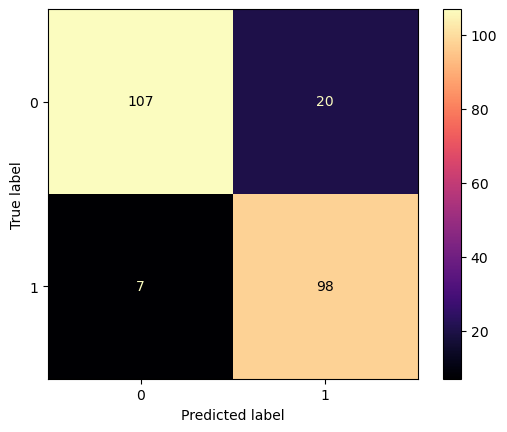

In [22]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixLR = ConfusionMatrixDisplay(cm_lr, display_labels= LR.classes_)
ConfusionMatrixLR.plot(cmap="magma")


### SVM

In [23]:
SVC = SVC(random_state=rs)
SVC.fit(X_train, y_train)
y_pred_svc = SVC.predict(X_test)

In [24]:
train_accuracy_svc = accuracy_score(y_train, SVC.predict(X_train))
test_accuracy_svc = accuracy_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc)

print("Train-Accuracy:", np.round(train_accuracy_svc, 4))
print("Test-Accuracy:", np.round(test_accuracy_svc,4))
print("F1-Score:", np.round(f1_svc,4))

Train-Accuracy: 0.7234
Test-Accuracy: 0.6509
F1-Score: 0.64


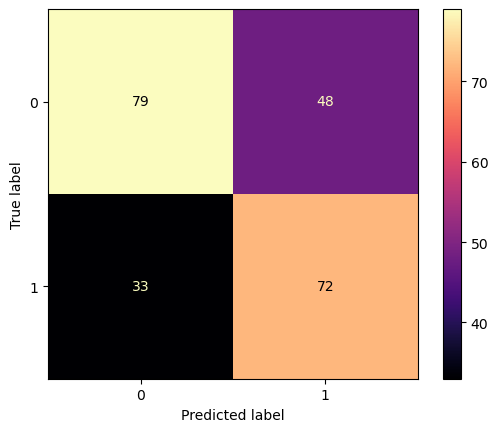

In [25]:
cm_svc = confusion_matrix(y_test, y_pred_svc)
ConfusionMatrixSVC = ConfusionMatrixDisplay(cm_svc, display_labels= np.array([0,1]))
ConfusionMatrixSVC.plot(cmap="magma")

### Random Forest

##### Without CV

In [26]:
RF = RandomForestClassifier(random_state=rs)
RF.fit(X_train, y_train)
y_pred_rf = RF.predict(X_test)

In [27]:
train_accuracy_rf = accuracy_score(y_train, RF.predict(X_train))
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Train-Accuracy:", np.round(train_accuracy_rf, 4))
print("Test-Accuracy:", np.round(test_accuracy_rf,4))
print("F1-Score:", np.round(f1_rf,4))

Train-Accuracy: 1.0
Test-Accuracy: 0.9052
F1-Score: 0.9


Here one can see that our Random Forest Model is overfitting since we got a 100% accuracy during training. In order to reduce this overfitting we search for fitting hyperparameters via GridSearch Cross Validation.

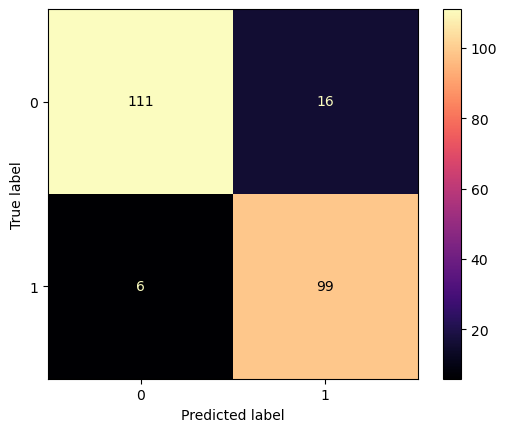

In [28]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixRF = ConfusionMatrixDisplay(cm_rf, display_labels= np.array([0,1]))
ConfusionMatrixRF.plot(cmap="magma")

##### With CV

In [29]:
param_grid = {'n_estimators': [2*n+1 for n in range(len(cleaned_heart_df.columns))],
             'max_depth':[2*n+1 for n in range(10)],
             'max_features':["auto", "sqrt", "log2"]}

In [30]:
search = GridSearchCV(estimator=RF, param_grid=param_grid, scoring="accuracy")
search.fit(X_train, y_train)
y_pred_rfs = search.predict(X_test)

In [31]:
print(f"Best Hyperparams: {search.best_params_}")

Best Hyperparams: {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 9}


In [32]:
train_accuracy_rfs = accuracy_score(y_train, search.predict(X_train))
test_accuracy_rfs = accuracy_score(y_test, y_pred_rfs)
f1_rfs = f1_score(y_test, y_pred_rfs)

print("Train-Accuracy:", np.round(train_accuracy_rfs, 4))
print("Test-Accuracy:", np.round(test_accuracy_rfs,4))
print("F1-Score:", np.round(f1_rfs,4))

Train-Accuracy: 0.8596
Test-Accuracy: 0.9009
F1-Score: 0.8969


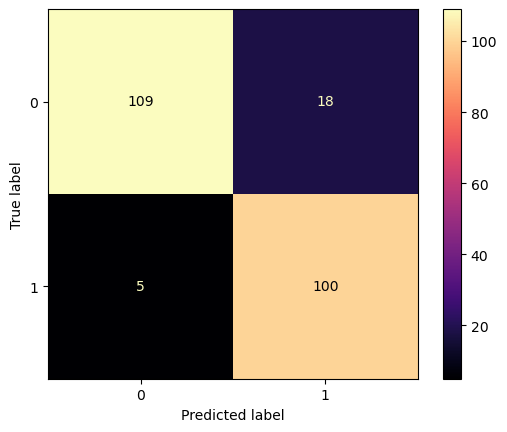

In [33]:
cm_rfs = confusion_matrix(y_test, y_pred_rfs)
ConfusionMatrixRF = ConfusionMatrixDisplay(cm_rfs, display_labels= np.array([0,1]))
ConfusionMatrixRF.plot(cmap="magma")

## Evaluation

In [34]:
models = ["Logistic Regression", "SVM", "Random Forest without CV", "Random Forest with CV"]
train_accs = [train_accuracy_lr, train_accuracy_svc, train_accuracy_rf, train_accuracy_rfs]
test_accs = [test_accuracy_lr, test_accuracy_svc, test_accuracy_rf, test_accuracy_rfs]
f1_scores = [f1_lr, f1_svc, f1_rf, f1_rfs]

In [35]:
Eval_df = pd.DataFrame({"Model": models, "Training Accuracy": train_accs, "Test Accuracy": test_accs, "F1-Score":f1_scores})

In [36]:
Eval_df

,Model,Training Accuracy,Test Accuracy,F1-Score
0,Logistic Regression,0.831915,0.883621,0.878924
1,SVM,0.723404,0.650862,0.640000
2,Random Forest without CV,1.000000,0.905172,0.900000
3,Random Forest with CV,0.859574,0.900862,0.896861


## Results

#### According to my results the best model is the Random Forest with GridSearch Cross-Validation, which is not as overfitting as the Random Forest without Cross-Validation-Model, but still delivers a high accuracy with ~90%. The F1-Scores also emphasize this particular deduction, since we get the highest F1-Scores for the Random Forest Classifiers.

#### To further improve the performance of the model one can increase the amount of data or use other ensemble methods as boosting. We could also try to increase the amount of regularization in order to prevent overfitting, but this could also lead to a lower perfomance although the model would generalize better.